# Time series analysis from Kaggle Notebook
https://www.kaggle.com/code/kashnitsky/topic-9-part-1-time-series-analysis-in-python

In [2]:
import warnings                                  # `do not disturb` mode
warnings.filterwarnings('ignore')

from dateutil.relativedelta import relativedelta # working with dates with style
import hvplot as hv
import hvplot.pandas
from itertools import product                    # some useful functions
import matplotlib.pyplot as plt                  # plots
import numpy as np                               # vectors and matrices
import pandas as pd                              # tables and data manipulations
from pathlib import Path
from pypalettes import load_cmap, add_cmap
import seaborn as sns                            # more plots
from scipy.optimize import minimize              # for function minimization
import scipy.stats as scs
from sklearn.metrics import mean_absolute_percentage_error as mape
import statsmodels.api as sm
import statsmodels.formula.api                     # statistics and econometrics
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tools.eval_measures import rmspe, rmse
from statsmodels.tsa.api import (kpss, adfuller, seasonal_decompose, STL)
import statsmodels.tsa.api as smt
from statsmodels.tsa.statespace.sarimax import SARIMAX
import tqdm

# Set plot styles
plt.rcParams["figure.figsize"] = [30, 5]
plt.style.use('grayscale')


# Festlegen der Farben
cmap = load_cmap("Apricot")
cmap_continuous = add_cmap(
    colors=["#FFFFFFFF", "#FFF9A1FF", "#BAD09DFF", "#76D3CFFF", "#459E9EFF", "#306677FF", "#24385FFF", "#132157FF"],
    name="apricot_continuous",
    cmap_type="continuous"
)
cmap8 = add_cmap(
    colors=['#D72000FF', '#EE6100FF', '#FFAD0AFF', '#FFD700FF', '#1BB6AFFF', '#005F73FF', '#9093A2FF', '#132157FF'],
    name="apricot8colors",
    cmap_type="discrete"
)
cmap7 = add_cmap(
    colors=['#D72000FF', '#EE6100FF', '#FFAD0AFF', '#FFD700FF', '#1BB6AFFF', '#9093A2FF', '#132157FF'],
    name="apricot7colors",
    cmap_type="discrete"
)


%matplotlib inline



In [3]:
# Load Timestamp of Dataset
df_daily = pd.read_csv('df_daily.csv')
df_hourly = pd.read_csv('df_hourly_2020.csv')
df_daily_test = pd.read_csv('df_daily_2024.csv')
df_hourly_test = pd.read_csv('df_hourly_2024.csv')


## Time series analysis in Python
Analyse aus: https://www.kaggle.com/code/kashnitsky/topic-9-part-1-time-series-analysis-in-python/notebook 25.07.24, 10:56
Und aus Atwan.2022: *Time Series Analysis*. 10 Building Univariate Time Series Models Using Statistical Methods: https://learning.oreilly.com/library/view/time-series-analysis/9781805124283/text/ch011.xhtml#join-our-book-community-on-discord-9

### Hilfsfunkktionen: check_stationarity, get_top_models_df, plot_forecast, combinator

In [8]:
def check_stationarity(df):
    results = adfuller(df)[1:3]
    s = 'Non-Stationary'
    if results[0] < 0.05:
        s = 'Stationary'
    print(f"'{s}\t p-value:{results[0]} \t lags:{results[1]}")
    return (s, results[0])

def get_top_models_df(scores, criterion='AIC', top_n=5):
    sorted_scores = sorted(scores.items(),
                           key=lambda item: item[1][criterion])
   
    top_models = sorted_scores[:top_n]
    data = [v for k, v in top_models]
    df = pd.DataFrame(data)
   
    df['model_id'] = [k for k, v in top_models]
    df.set_index('model_id', inplace=True)
    return df

def plot_forecast(model, start, train, test):
    forecast = pd.DataFrame(model.forecast(test.shape[0]),
                            index=test.index)
    ax = train.loc[start:].plot(style='--')
    test.plot(ax=ax)
    forecast.plot(ax=ax, style = '-.')
    ax.legend(['orig_train', 'orig_test', 'forecast'])
    plt.show()

def combinator(items):
    combo = [i for i in product(*items)]
    return combo

## Moving, Smoothing and Evaluation
### Berechnung des Gleitenden Mittelwertes


In [9]:
# Berechnung des Gleitenden Mittelwertes
def moving_average(series, n):
    """
        Calculate average of last n observations
    """
    return np.average(series[-n:])

moving_average(df_daily, 7) # Berechnung des Mittelswertes der letzten sieben Tage

TypeError: unsupported operand type(s) for +: 'int' and 'str'

In [26]:
def plotMovingAverage(series, window, plot_intervals=False, scale=1.96, plot_anomalies=False):
    """
        series - dataframe with timeseries
        window - rolling window size 
        plot_intervals - show confidence intervals
        plot_anomalies - show anomalies 
    """
    rolling_mean = series.rolling(window=window).mean()

    plt.figure(figsize=(15, 5))
    plt.title("Moving average\n window size = {}".format(window))
    
    # Plot actual values first to keep them in the background
    plt.plot(series, label="Actual values", color=cmap.colors[3])

    # Plot rolling mean trend
    plt.plot(rolling_mean, "g", label="Rolling mean trend", color=cmap.colors[1])

    # Plot confidence intervals for smoothed values
    if plot_intervals:
        mae = mean_absolute_error(series[window:], rolling_mean[window:])
        deviation = np.std(series[window:] - rolling_mean[window:])
        lower_bond = rolling_mean - (mae + scale * deviation)
        upper_bond = rolling_mean + (mae + scale * deviation)
        plt.plot(upper_bond, "r--", label="Upper Bond / Lower Bond")
        plt.plot(lower_bond, "r--")
        
        # Having the intervals, find abnormal values
        if plot_anomalies:
            anomalies = pd.DataFrame(index=series.index)
            anomalies[series < lower_bond] = series[series < lower_bond]
            anomalies[series > upper_bond] = series[series > upper_bond]
            plt.plot(anomalies, "ro", markersize=10)
        
    plt.legend(loc="upper left")
    plt.grid(True)
    plt.show()


In [ ]:
plotMovingAverage (df_daily['calls'], 7)



plotMovingAverage (df_daily['calls'], 30)



plotMovingAverage (df_daily['calls'], 365) 



plotMovingAverage(df_daily['calls'], 30, plot_intervals=True, plot_anomalies= True)


### Gewichteter Durchschnitt

In [10]:
def weighted_average(series, weights):
    """
        Calculate weighted average on the series.
        Assuming weights are sorted in descending order
        (larger weights are assigned to more recent observations).
    """
    result = 0.0
    for n in range(len(weights)):
        result += series.iloc[-n-1] * weights[n]
    return float(result)

In [11]:
weighted_average(df_daily['calls'], [0.6, 0.3, 0.1])

263.40000000000003

### Exponentielle Glättung

In [12]:
def exponential_smoothing(series, alpha):
    """
        series - dataset with timestamps
        alpha - float [0.0, 1.0], smoothing parameter
    """
    result = [series[0]] # first value is same as series
    for n in range(1, len(series)):
        result.append(alpha * series[n] + (1 - alpha) * result[n-1])
    return result

### Exponentielle Glättung

In [27]:
def exponential_smoothing(series, alpha):
    """
        series - dataset with timestamps
        alpha - float [0.0, 1.0], smoothing parameter
    """
    result = [series[0]] # first value is same as series
    for n in range(1, len(series)):
        result.append(alpha * series[n] + (1 - alpha) * result[n-1])
    return result

In [28]:
def plotExponentialSmoothing(series, alphas):
    """
        Plots exponential smoothing with different alphas
        
        series - dataset with timestamps
        alphas - list of floats, smoothing parameters
        
    """
    with plt.style.context('seaborn-v0_8-white'):    
        plt.figure(figsize=(15, 7))
        plt.plot(series.values, "c", label = "Actual")
        for alpha in alphas:
            plt.plot(exponential_smoothing(series, alpha), label="Alpha {}".format(alpha))
        plt.legend(loc="best")
        plt.axis('tight')
        plt.title("Exponential Smoothing")
        plt.grid(True)

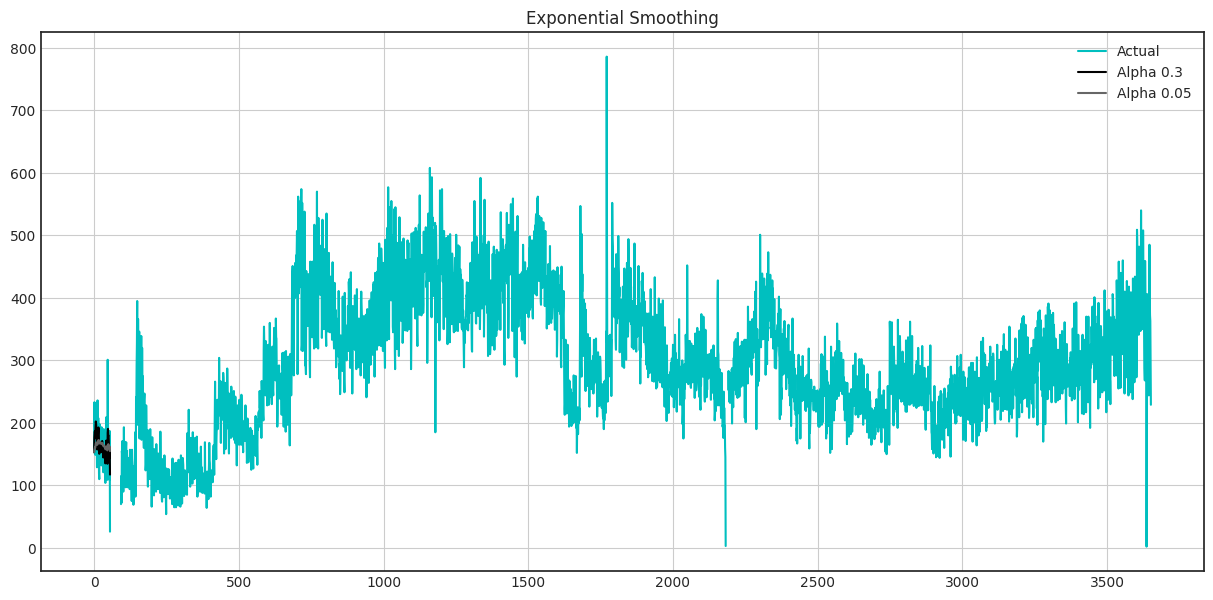

In [29]:
plotExponentialSmoothing(df_daily.calls, [0.3, 0.05])

Alpha ist der Glättungs-Faktor. Je kleiner alpha ist, desto mehr Einfluss haben die vorherigen Ereignisse im Vergleich zum momentanen Ereignis.


## Double exponential smoothing


In [30]:
def double_exponential_smoothing(series, alpha, beta):
    """
        series - dataset with timeseries
        alpha - float [0.0, 1.0], smoothing parameter for level
        beta - float [0.0, 1.0], smoothing parameter for trend
    """
    # first value is same as series
    result = [series[0]]
    for n in range(1, len(series)+1):
        if n == 1:
            level, trend = series[0], series[1] - series[0]
        if n >= len(series): # forecasting
            value = result[-1]
        else:
            value = series[n]
        last_level, level = level, alpha*value + (1-alpha)*(level+trend)
        trend = beta*(level-last_level) + (1-beta)*trend
        result.append(level+trend)
    return result

def plotDoubleExponentialSmoothing(series, alphas, betas):
    """
        Plots double exponential smoothing with different alphas and betas
        
        series - dataset with timestamps
        alphas - list of floats, smoothing parameters for level
        betas - list of floats, smoothing parameters for trend
    """
    
    with plt.style.context('seaborn-v0_8-white'):    
        plt.figure(figsize=(20, 8))
        plt.plot(series.values, label = "Actual")
        for alpha in alphas:
            for beta in betas:
                plt.plot(double_exponential_smoothing(series, alpha, beta), label="Alpha {}, beta {}".format(alpha, beta))
        plt.legend(loc="best")
        plt.axis('tight')
        plt.title("Double Exponential Smoothing")
        plt.grid(True)

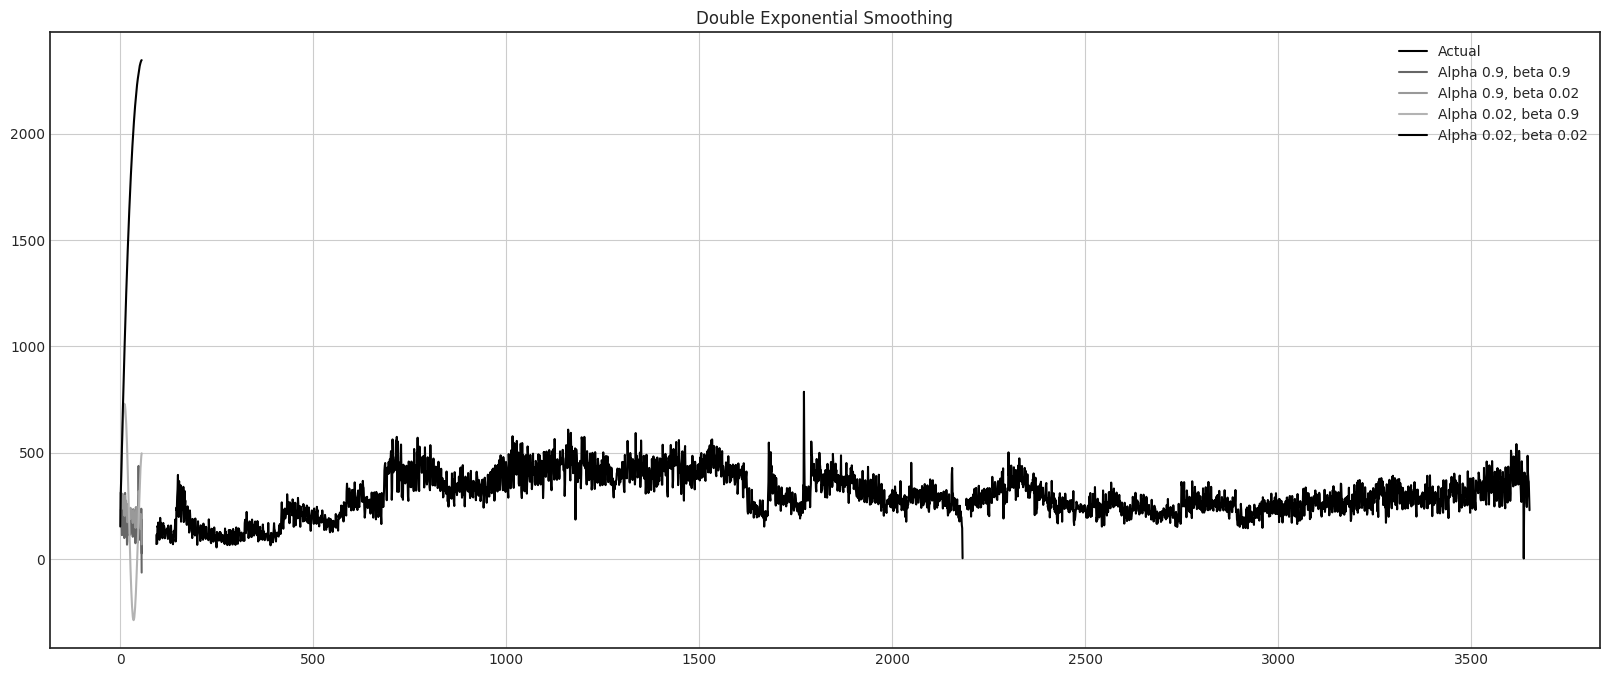

In [31]:
plotDoubleExponentialSmoothing(df_daily.calls, alphas=[0.9, 0.02], betas=[0.9, 0.02])

Die doppelte Exponentielle Glättung beinhaltet die Komponenten Level und Trend. 

### Triple Exponential Smoothing aka Holt-Winters

Dieses Verfahren berücksichtigt nicht nur Level und Trend, sondern auch Season/Saison.

In [32]:
class HoltWinters:
    """
    Holt-Winters model with the anomalies detection using Brutlag method
    
    # series - initial time series
    # slen - length of a season
    # alpha, beta, gamma - Holt-Winters model coefficients
    # n_preds - predictions horizon
    # scaling_factor - sets the width of the confidence interval by Brutlag (usually takes values from 2 to 3)
    """
    
    def __init__(self, series, slen, alpha, beta, gamma, n_preds, scaling_factor=1.96):
        self.series = series
        self.slen = slen
        self.alpha = alpha
        self.beta = beta
        self.gamma = gamma
        self.n_preds = n_preds
        self.scaling_factor = scaling_factor
        
    def initial_trend(self):
        sum = 0.0
        for i in range(self.slen):
            sum += float(self.series[i+self.slen] - self.series[i]) / self.slen
        return sum / self.slen  
    
    def initial_seasonal_components(self):
        seasonals = {}
        season_averages = []
        n_seasons = int(len(self.series)/self.slen)
        # let's calculate season averages
        for j in range(n_seasons):
            season_averages.append(sum(self.series[self.slen*j:self.slen*j+self.slen])/float(self.slen))
        # let's calculate initial values
        for i in range(self.slen):
            sum_of_vals_over_avg = 0.0
            for j in range(n_seasons):
                sum_of_vals_over_avg += self.series[self.slen*j+i]-season_averages[j]
            seasonals[i] = sum_of_vals_over_avg/n_seasons
        return seasonals   
      
    def triple_exponential_smoothing(self):
        self.result = []
        self.Smooth = []
        self.Season = []
        self.Trend = []
        self.PredictedDeviation = []
        self.UpperBond = []
        self.LowerBond = []
        
        seasonals = self.initial_seasonal_components()
        
        for i in range(len(self.series)+self.n_preds):
            if i == 0: # components initialization
                smooth = self.series[0]
                trend = self.initial_trend()
                self.result.append(self.series[0])
                self.Smooth.append(smooth)
                self.Trend.append(trend)
                self.Season.append(seasonals[i%self.slen])
                
                self.PredictedDeviation.append(0)
                
                self.UpperBond.append(self.result[0] + 
                                      self.scaling_factor * 
                                      self.PredictedDeviation[0])
                
                self.LowerBond.append(self.result[0] - 
                                      self.scaling_factor * 
                                      self.PredictedDeviation[0])
                continue
                
            if i >= len(self.series): # predicting
                m = i - len(self.series) + 1
                self.result.append((smooth + m*trend) + seasonals[i%self.slen])
                
                # when predicting we increase uncertainty on each step
                self.PredictedDeviation.append(self.PredictedDeviation[-1]*1.01) 
                
            else:
                val = self.series[i]
                last_smooth, smooth = smooth, self.alpha*(val-seasonals[i%self.slen]) + (1-self.alpha)*(smooth+trend)
                trend = self.beta * (smooth-last_smooth) + (1-self.beta)*trend
                seasonals[i%self.slen] = self.gamma*(val-smooth) + (1-self.gamma)*seasonals[i%self.slen]
                self.result.append(smooth+trend+seasonals[i%self.slen])
                
                # Deviation is calculated according to Brutlag algorithm.
                self.PredictedDeviation.append(self.gamma * np.abs(self.series[i] - self.result[i]) 
                                               + (1-self.gamma)*self.PredictedDeviation[-1])
                     
            self.UpperBond.append(self.result[-1] + 
                                  self.scaling_factor * 
                                  self.PredictedDeviation[-1])

            self.LowerBond.append(self.result[-1] - 
                                  self.scaling_factor * 
                                  self.PredictedDeviation[-1])

            self.Smooth.append(smooth)
            self.Trend.append(trend)
            self.Season.append(seasonals[i%self.slen])

### Time Series Cross Validation

In [33]:
from sklearn.model_selection import TimeSeriesSplit # you have everything done for you

def timeseriesCVscore(params, series, loss_function=mean_squared_error, slen=24):
    """
        Returns error on CV  
        
        params - vector of parameters for optimization
        series - dataset with timeseries
        slen - season length for Holt-Winters model
    """
    # errors array
    errors = []
    
    values = series.values
    alpha, beta, gamma = params
    
    # set the number of folds for cross-validation
    tscv = TimeSeriesSplit(n_splits=3) 
    
    # iterating over folds, train model on each, forecast and calculate error
    for train, test in tscv.split(values):
        model = HoltWinters(series=values[train], slen=slen, 
                            alpha=alpha, beta=beta, gamma=gamma, n_preds=len(test))
        model.triple_exponential_smoothing()
        
        predictions = model.result[-len(test):]
        actual = values[test]
        error = loss_function(actual, predictions)
        errors.append(error)
        
    return np.mean(np.array(errors))

NameError: name 'mean_squared_error' is not defined

In [34]:
%%time
data = df_daily.calls[:-20] # leave some data for testing

# initializing model parameters alpha, beta and gamma
x = [0, 0, 0] 

# Minimizing the loss function
opt = minimize(timeseriesCVscore, x0=x, 
               args=(data, mean_squared_log_error), 
               method="TNC", bounds = ((0, 1), (0, 1), (0, 1))
              )

# Take optimal values...
alpha_final, beta_final, gamma_final = opt.x
print(alpha_final, beta_final, gamma_final)

# ...and train the model with them, forecasting for the next 50 hours
model = HoltWinters(data, slen = 24, 
                    alpha = alpha_final, 
                    beta = beta_final, 
                    gamma = gamma_final, 
                    n_preds = 50, scaling_factor = 3)
model.triple_exponential_smoothing()

NameError: name 'timeseriesCVscore' is not defined

In [35]:
from sklearn.metrics import mean_squared_error
from scipy.optimize import minimize
import numpy as np
import pandas as pd

# Check for negative values
negative_values = df_daily.calls[df_daily.calls < 0]
print(f"Negative values in calls: {negative_values}")

if len(negative_values) > 0:
    raise ValueError("The data contains negative values, which is not suitable for mean_squared_log_error.")

def timeseriesCVscore(params, series, loss_function=mean_squared_error, slen=24):
    """
        Returns error on CV  
        
        params - vector of parameters for optimization
        series - dataset with timeseries
        slen - season length for Holt-Winters model
    """
    # errors array
    errors = []
    
    values = series.values
    alpha, beta, gamma = params
    
    # set the number of folds for cross-validation
    tscv = TimeSeriesSplit(n_splits=3) 
    
    # iterating over folds, train model on each, forecast and calculate error
    for train, test in tscv.split(values):
        model = HoltWinters(series=values[train], slen=slen, 
                            alpha=alpha, beta=beta, gamma=gamma, n_preds=len(test))
        model.triple_exponential_smoothing()
        
        predictions = model.result[-len(test):]
        actual = values[test]
        error = loss_function(actual, predictions)
        errors.append(error)
        
    return np.mean(np.array(errors))

data = df_daily.calls[:-20]  # Belassen Sie einige Daten zum Testen

# Initialisieren Sie die Modellparameter alpha, beta und gamma
x = [0, 0, 0] 

# Minimieren Sie die Verlustfunktion
opt = minimize(timeseriesCVscore, x0=x, 
               args=(data, mean_squared_error), 
               method="TNC", bounds = ((0, 1), (0, 1), (0, 1))
              )

# Nehmen Sie die optimalen Werte...
alpha_final, beta_final, gamma_final = opt.x
print(alpha_final, beta_final, gamma_final)

# ...und trainieren Sie das Modell mit ihnen, indem Sie die nächsten 50 Stunden vorhersagen
model = HoltWinters(data, slen = 24, 
                    alpha = alpha_final, 
                    beta = beta_final, 
                    gamma = gamma_final, 
                    n_preds = 50, scaling_factor = 3)
model.triple_exponential_smoothing()

Negative values in calls: Series([], Name: calls, dtype: float64)


ValueError: Input contains NaN.

In [37]:
def plotHoltWinters(series, plot_intervals=False, plot_anomalies=False):
    """
        series - dataset with timeseries
        plot_intervals - show confidence intervals
        plot_anomalies - show anomalies 
    """
    
    plt.figure(figsize=(20, 10))
    plt.plot(series.values, label = "Actual")
    plt.plot(model.result, label = "Model")
    error = mean_absolute_percentage_error(series.values, model.result[:len(series)])
    plt.title("Mean Absolute Percentage Error: {0:.2f}%".format(error))
    
    if plot_anomalies:
        anomalies = np.array([np.NaN]*len(series))
        anomalies[series.values<model.LowerBond[:len(series)]] = \
            series.values[series.values<model.LowerBond[:len(series)]]
        anomalies[series.values>model.UpperBond[:len(series)]] = \
            series.values[series.values>model.UpperBond[:len(series)]]
        plt.plot(anomalies, "o", markersize=10, label = "Anomalies")
    
    if plot_intervals:
        plt.plot(model.UpperBond, "r--", alpha=0.5, label = "Up/Low confidence")
        plt.plot(model.LowerBond, "r--", alpha=0.5)
        plt.fill_between(x=range(0,len(model.result)), y1=model.UpperBond, 
                         y2=model.LowerBond, alpha=0.2, color = "grey")    
        
    plt.vlines(len(series), ymin=min(model.LowerBond), ymax=max(model.UpperBond), linestyles='dashed')
    plt.axvspan(len(series)-20, len(model.result), alpha=0.3, color='lightgrey')
    plt.grid(True)
    plt.axis('tight')
    plt.legend(loc="best", fontsize=13);

AttributeError: 'SARIMAXResults' object has no attribute 'result'

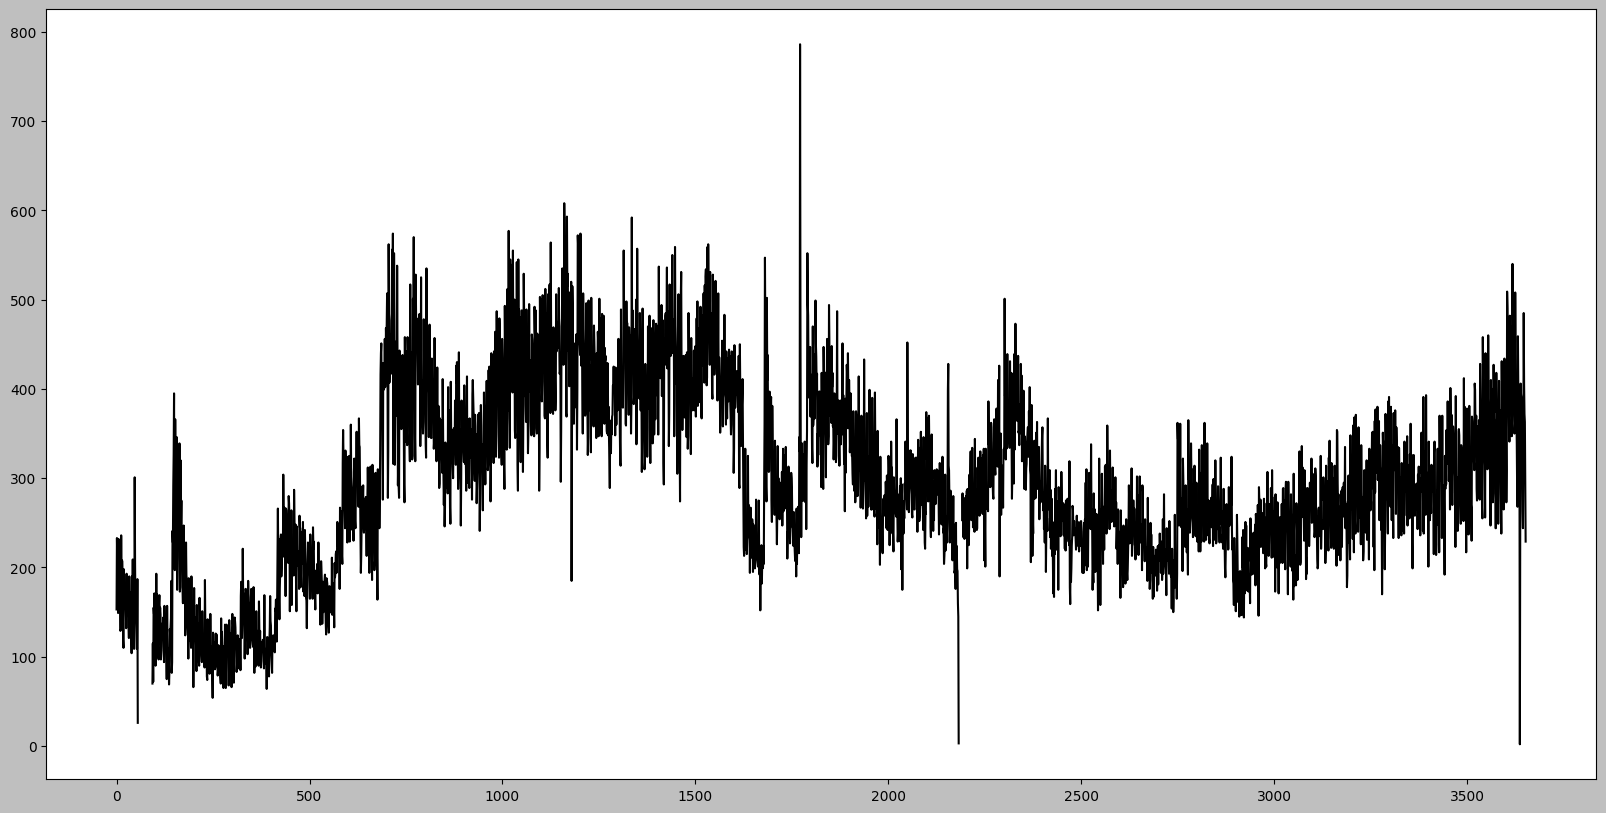

In [38]:
plotHoltWinters(df_daily.calls, plot_intervals=True, plot_anomalies=True)

In [39]:
plt.figure(figsize=(25, 5))
plt.plot(model.PredictedDeviation)
plt.grid(True)
plt.axis('tight')
plt.title("Brutlag's predicted deviation");

AttributeError: 'SARIMAXResults' object has no attribute 'PredictedDeviation'

<Figure size 2500x500 with 0 Axes>

## Econometric approach

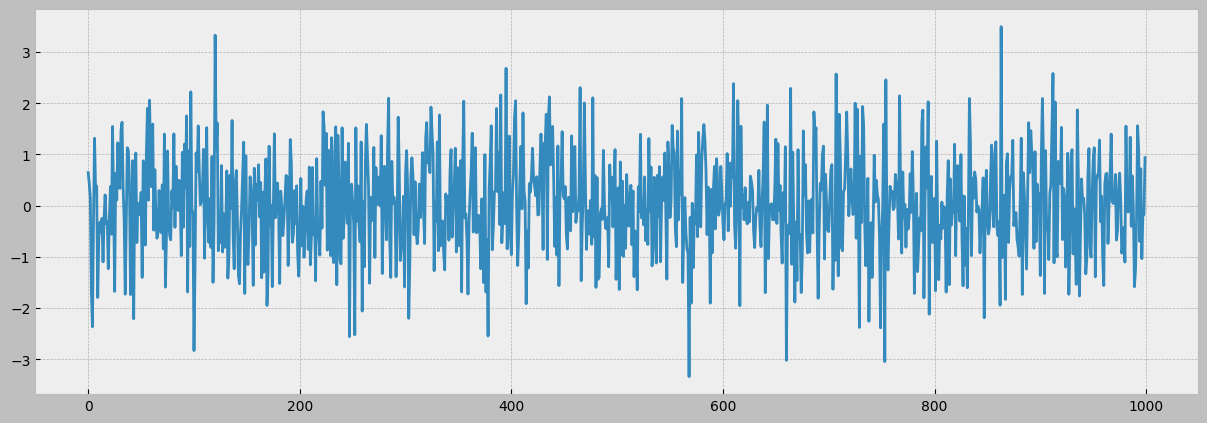

In [40]:
white_noise = np.random.normal(size=1000)
with plt.style.context('bmh'):  
    plt.figure(figsize=(15, 5))
    plt.plot(white_noise)

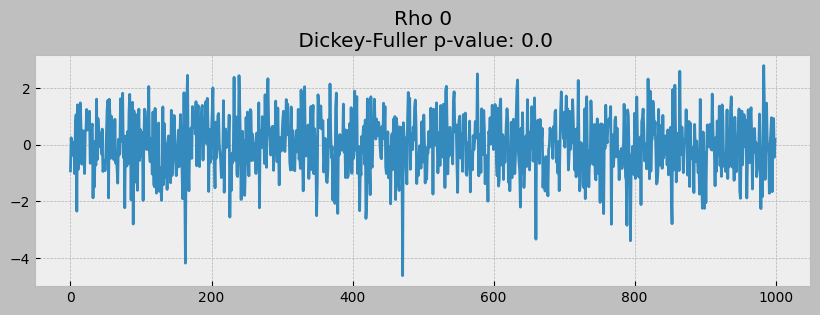

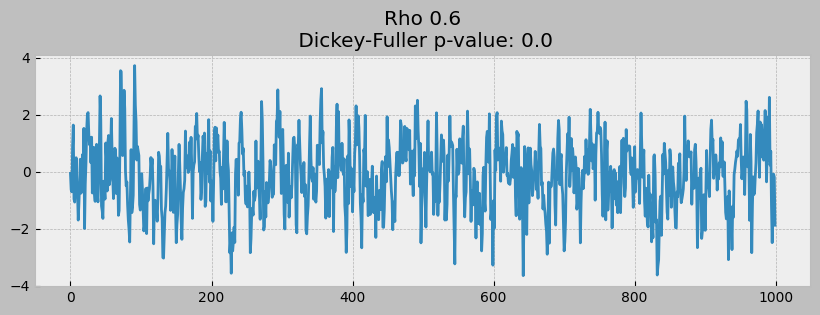

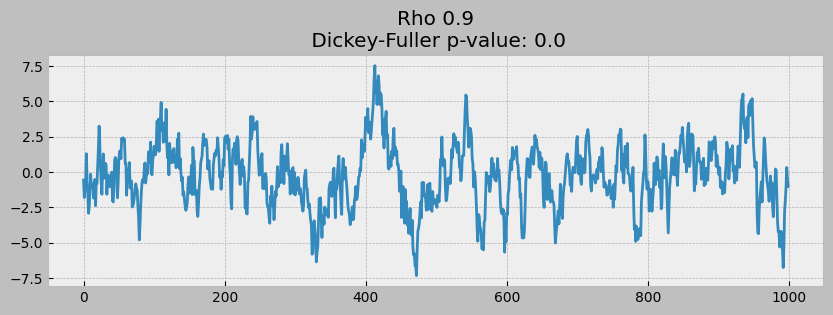

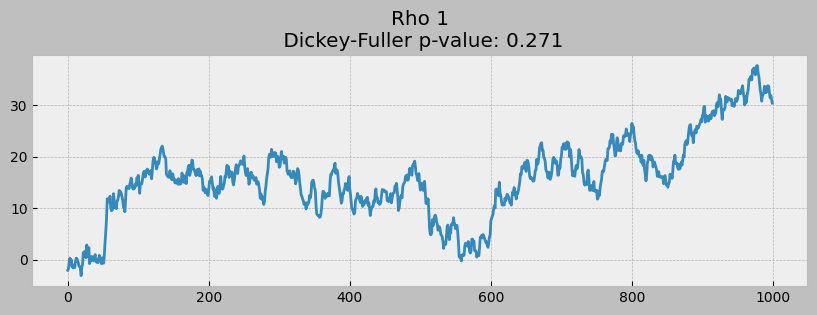

In [41]:
def plotProcess(n_samples=1000, rho=0):
    x = w = np.random.normal(size=n_samples)
    for t in range(n_samples):
        x[t] = rho * x[t-1] + w[t]

    with plt.style.context('bmh'):  
        plt.figure(figsize=(10, 3))
        plt.plot(x)
        plt.title("Rho {}\n Dickey-Fuller p-value: {}".format(rho, round(sm.tsa.stattools.adfuller(x)[1], 3)))
        
for rho in [0, 0.6, 0.9, 1]:
    plotProcess(rho=rho)